## Этап 1. Подготовка

In [107]:
# установим свежий scikit-learn для поддержки в OneHotEncoder одновременно drop='first' и handle_unknown='ignore'
!pip install scikit-learn==1.1.3

# установим phik для анализа корреляции данных
!pip install phik

# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import (
    LGBMClassifier,
    log_evaluation
)
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve
)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
# зафиксируем параметр random state
RS = 140823

# отобразим все столбцы в таблицах
pd.set_option('display.max_columns', None)

In [108]:
# загрузим данные из локальной папки
contract = pd.read_csv('contract_new.csv')
personal = pd.read_csv('personal_new.csv')
internet = pd.read_csv('internet_new.csv')
phone = pd.read_csv('phone_new.csv')

## Этап 2. Исследовательский анализ данных

### Этап 2.1. Исследование данных о договоре

#### Этап 2.1.1. Общая информация о данных

In [109]:
# напишем функцию для проверки датасета
def check_data(df):
    display(
        df.info(),
        df.nunique(),
        df.describe(include='all'),
        df.head(),
        df.sample(5, random_state=RS)
    )
    print('Дубликатов строк:', df.duplicated().sum())

In [110]:
# проверим датасет с информацией о договорах
check_data(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

customerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,6729-GDNGC,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2248,9554-DFKIC,2017-08-01,No,Month-to-month,Yes,Bank transfer (automatic),54.45,1731.51
5204,4282-ACRXS,2016-12-01,No,Month-to-month,Yes,Electronic check,24.85,944.3
6865,8792-AOROI,2019-06-01,No,Two year,No,Mailed check,65.50,524.0
1667,4403-BWPAY,2018-12-01,2019-11-01,One year,Yes,Credit card (automatic),24.80,272.8
6947,2898-MRKPI,2014-06-01,No,One year,Yes,Credit card (automatic),101.05,6871.4


Дубликатов строк: 0


В столбце TotalCharges есть пустые строки. Проверим их:

In [111]:
# посчитаем пустые строки в столбце TotalCharges
print(len(contract[contract['TotalCharges'] == ' ']))

# выведем на экран строки с пустыми значениями в TotalCharges
contract[contract['TotalCharges'] == ' ']

11


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


В столбце TotalCharges 11 пустых значений: договоры с такими значенями были заключены в последний месяц сбора данных, поэтому действуют неполный месяц и данные для TotalCharges еще не успели накопиться. Поэтому будет кореектно заменить пустые строки нулями:

In [112]:
# в столбце TotalCharges заменим пустые строки на нули
contract['TotalCharges'].replace(' ', 0, inplace=True)

# проверим результат
contract[contract['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


У столбцов BeginDate, EndDate и TotalCharges тип данных - object, что мешает анализу. В прочих столбцах верные типы данных. Исправим некорректные типы данных:

In [113]:
# в столбце BeginDate изменим тип данных на datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

# чтобы корректно поменять тип данных в столбце EndDate, заменим No на пропуски
contract['EndDate'].replace('No', np.NaN, inplace=True)

# в столбце EndDate изменим тип данных на datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

# в столбце TotalCharges изменим тип данных на числа с плавающей точкой
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

# проверим результат
check_data(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


/tmp/ipykernel_153/1623070718.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all'),
/tmp/ipykernel_153/1623070718.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all'),


None

customerID          7043
BeginDate             77
EndDate               66
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
dtype: int64

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,1101,7043,7043,7043,7043.000000,7043.000000
unique,7043,77,66,3,2,4,NaN,NaN
top,6729-GDNGC,2014-02-01 00:00:00,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,366,39,3875,4171,2365,NaN,NaN
first,NaN,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2248,9554-DFKIC,2017-08-01,NaT,Month-to-month,Yes,Bank transfer (automatic),54.45,1731.51
5204,4282-ACRXS,2016-12-01,NaT,Month-to-month,Yes,Electronic check,24.85,944.30
6865,8792-AOROI,2019-06-01,NaT,Two year,No,Mailed check,65.50,524.00
1667,4403-BWPAY,2018-12-01,2019-11-01,One year,Yes,Credit card (automatic),24.80,272.80
6947,2898-MRKPI,2014-06-01,NaT,One year,Yes,Credit card (automatic),101.05,6871.40


Дубликатов строк: 0


In [114]:
# посчитаем долю расторгнутых договоров
len(contract['EndDate'].dropna()) / len(contract)

0.15632542950447254

**В данных:**

- нет полных дубликатов строк и нет дубликатов по customerID
- доступны договоры, заключенные с октября 2013 по февраль 2020 включительно
- первое расторжение договора произошло в июне 2014, последнее расторжение - в январе 2020
- самый активный период заключения договоров - февраль 2014
- расторгнуто около 16% от всех заключенных договоров
- наиболее популярна помесячная оплата услуг
- чаще всего применяется электронный чек
- средняя оплата в месяц составляет около 64.76
- средняя оплата в год - около 2115.31
- в столбце TotalCharges 11 нулевых значений: договоры с такими значенями были заключены в последний месяц сбора данных, поэтому действуют неполный месяц и данные для TotalCharges еще не успели накопиться. Поэтому нулевые значения корректны в этом случае

Далее рассмотрим распределение значений в данных:

#### Этап 2.1.2. Анализ распределений значений

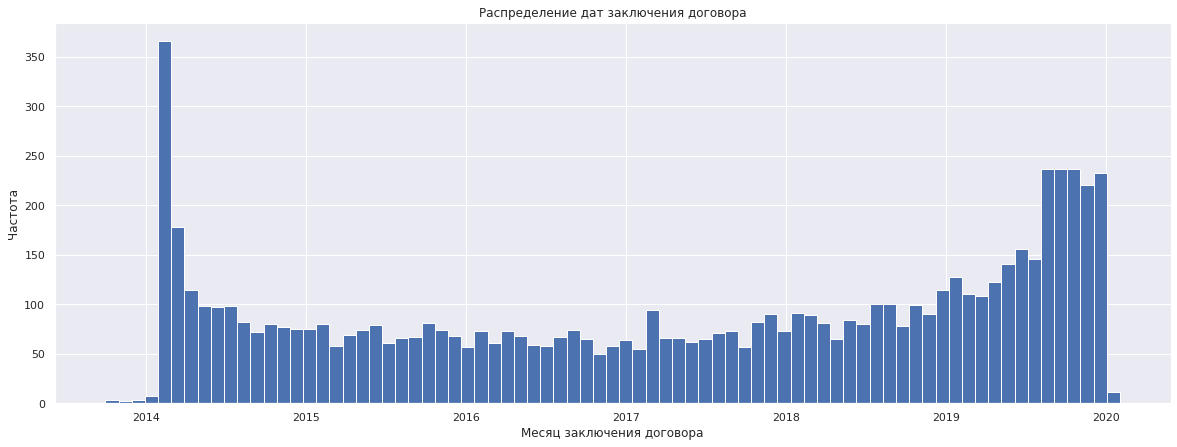

In [115]:
# посмотрим на распределение дат заключения договора
# используем стиль графиков seaborn
sns.set_theme()
plt.figure(figsize=(20, 7))
contract['BeginDate'].hist(bins=77);
plt.title('Распределение дат заключения договора')
plt.ylabel('Частота')
plt.xlabel('Месяц заключения договора')
plt.show()

В начале периода наблюдений, с октября 2013 по январь 2014 было заключено незначительное количество договоров. Затем в феврале 2014 следует резкий приток новых клиентов: заключено около 370 договоров. Возможно, это связано в выходом компании на массовый рынок и/или широкой маркетинговой поддержкой. Весной и летом 2014 количество заключенных договоров снижается и в последующих месяцах стабильно колеблется в промежутке около 50-90 договоров в месяц.

Ситуация начинает менятся в 2019 году: в первой половине года поток новых клиентов плавно растет. Осенью 2019 следуют внезапный скачок заключения договоров до порога 240 договоров в месяц. Февраль 2020 вошел в данные не полностью, поэтому приток клиентов в этом месяце незначителен.

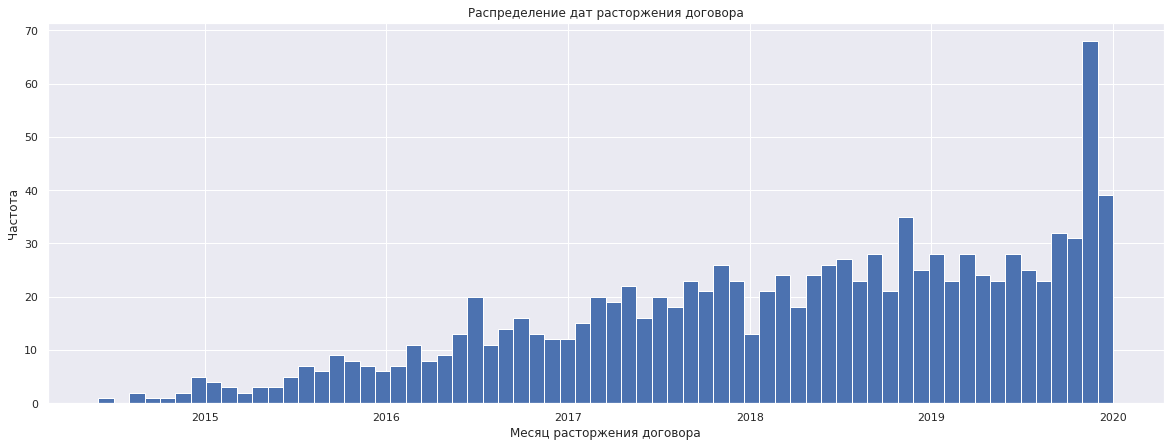

In [116]:
# посмотрим на распределение дат расторжения договора
plt.figure(figsize=(20, 7))
contract['EndDate'].hist(bins=66);
plt.title('Распределение дат расторжения договора')
plt.ylabel('Частота')
plt.xlabel('Месяц расторжения договора')
plt.show()

До 2015 года расторжения единичны. Затем количество расторгнутых в месяц договоров плавно растет с течением времени. В 2018-2019 году отток клиентов стабилизируется в коридоре 20-28 расторжений в месяц. В декабре 2019 заметно резкое увеличение расторгонутых договоров - до 68. В январе 2020 оттток снижается, но все еще довольно заметен. По февралю 2020 данных нет, поскольку месяц представлен неполно.

В данных очевидна тенденция к оттоку клиентов: проблема явно требует решения.

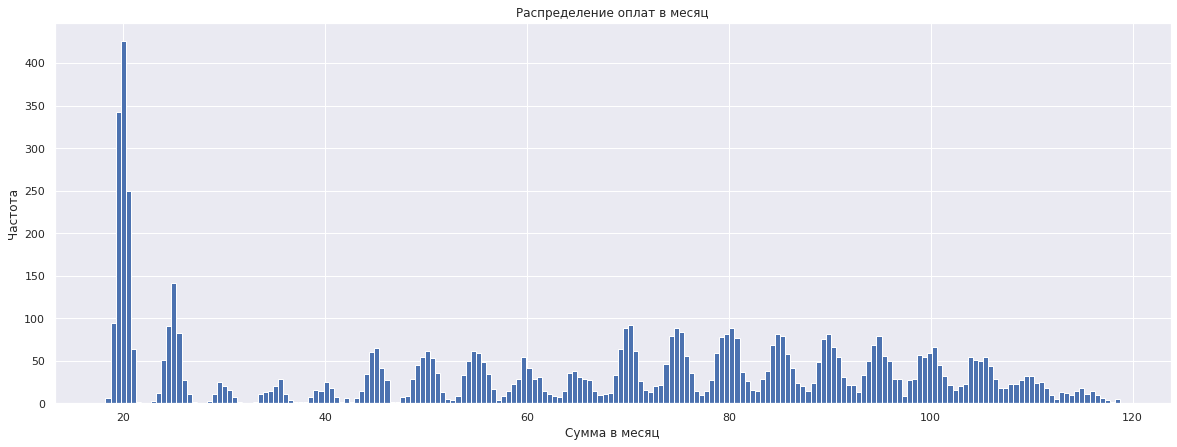

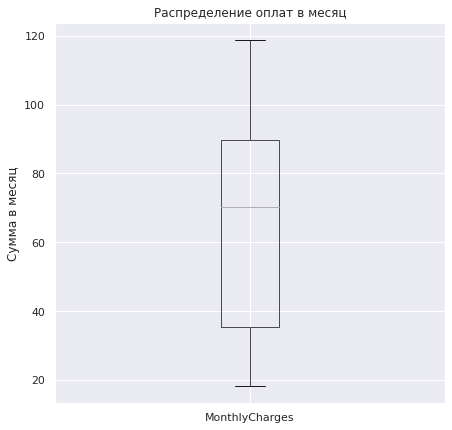

In [117]:
# посмотрим на распределение оплат в месяц
plt.figure(figsize=(20, 7))
contract['MonthlyCharges'].hist(bins=200);
plt.title('Распределение оплат в месяц')
plt.ylabel('Частота')
plt.xlabel('Сумма в месяц')
plt.show()

# проверим на аномалии оплаты в месяц
plt.figure(figsize=(7, 7))
contract.boxplot(column='MonthlyCharges')
plt.title('Распределение оплат в месяц')
plt.ylabel('Сумма в месяц')
plt.show()

Помесячные оплаты сконцентрированы вокруг круглых значений: например, 20, 30, 40, 60, 65 и т.д. Вероятно это обусловнено тарифами с круглыми значениями абонентской платы, к которой могут прибавляется дополнительные услуги.

Для значительно части клиентов плата в месяц составляет около 20. Меньше всего клиентов в диапазоне 30-40 в месяц. Прочие суммы выплат распределены довольно равномерно среди клиентов. Аномалий в этом столбце нет.

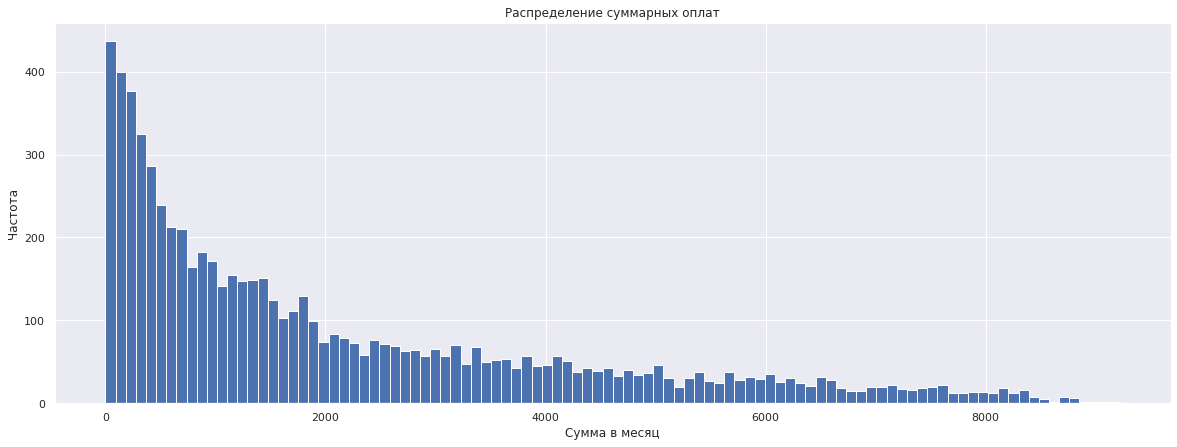

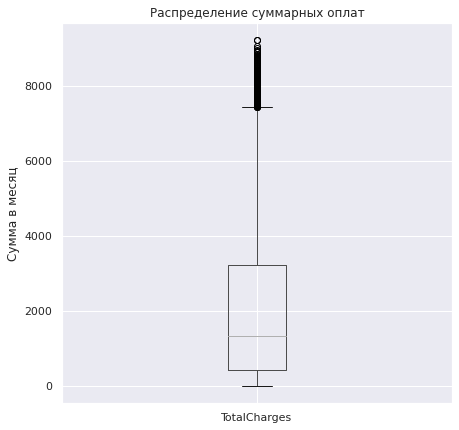

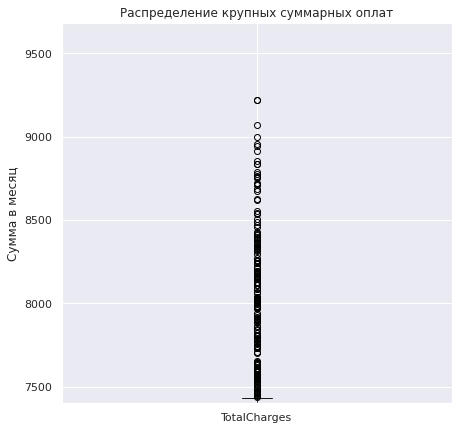

In [118]:
# посмотрим на распределение суммарных оплат
plt.figure(figsize=(20, 7))
contract['TotalCharges'].hist(bins=100);
plt.title('Распределение суммарных оплат')
plt.ylabel('Частота')
plt.xlabel('Сумма в месяц')
plt.show()

# проверим на аномалии суммарные оплаты
plt.figure(figsize=(7, 7))
contract.boxplot(column='TotalCharges')
plt.title('Распределение суммарных оплат')
plt.ylabel('Сумма в месяц')
plt.show()

# проверим на аномалии крупные суммарные оплаты
plt.figure(figsize=(7, 7))
contract.boxplot(column='TotalCharges')
plt.title('Распределение крупных суммарных оплат')
plt.ylabel('Сумма в месяц')
plt.ylim(7400,)
plt.show()

На графике общая сумма выплат плавно снижается, что логично: оператор планомерно увеличивает клиентскую базу, поэтому клиентов с небольшими суммарными выплатами довольно много. На графике ящика с усами видны аномалии крупных суммарных выплат. Предположим, что это постоянные клиенты, давно заключившие договоры. Проверим предположение, посчитав долю аномально крупных выплат, их количество и долю расторгнутых договоров среди аномально крупных оплат:

In [119]:
# посчитаем количество и долю аномально крупных суммарных оплат
print('Количество аномально крупных суммарных оплат:', 
      len(contract[contract['TotalCharges'] > 7450]))
print('Доля аномально крупных суммарных оплат', 
      len(contract[contract['TotalCharges'] > 7450]) / len(contract))

# посчитаем долю расторгнутых договоров среди договоров с аномально крупными выплатами
print('Доля расторгнутых договоров среди договоров с аномально крупными суммарными оплатами',
      len(contract['EndDate'].dropna()[contract['TotalCharges'] > 7450]) \
      / len(contract[contract['TotalCharges'] > 7450]))

Количество аномально крупных суммарных оплат: 193
Доля аномально крупных суммарных оплат 0.027403095271901177
Доля расторгнутых договоров среди договоров с аномально крупными суммарными оплатами 0.015544041450777202


Наше предположение подтвердилось: аномально крупные суммарные выплаты принадлежат самым лояльным клиентам. Таких клиентов очень мало, а доля расторгнутых договоров среди них лишь около 1.6%

### Этап 2.2. Исследование персональных данных клиента

In [120]:
# проверим датасет с персональными данными клиента
check_data(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,6729-GDNGC,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
2248,9554-DFKIC,Male,0,Yes,Yes
5204,4282-ACRXS,Male,1,Yes,No
6865,8792-AOROI,Female,0,Yes,No
1667,4403-BWPAY,Male,0,No,No
6947,2898-MRKPI,Male,0,Yes,Yes


Дубликатов строк: 0


**В данных:**

- количество строк совпадает с датасетом, содержащим информацию о договорах: скорее всего customerID в этих датасетах идентичны
- типы данных корректны
- дубликатов срок, дубликатов в столбце customerID и пропусков нет
- примерно 16% клиентов имеют пенсионный статус по возрасту

### Этап 2.3. Исследование информации об интернет-услугах

In [121]:
check_data(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5884-GCYMI,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1017,4598-ZADCK,DSL,Yes,Yes,Yes,Yes,Yes,No
1202,7898-PDWQE,DSL,Yes,Yes,Yes,Yes,No,Yes
2631,4680-KUTAJ,DSL,Yes,No,No,No,No,No
2607,1125-SNVCK,DSL,No,No,No,No,No,No
2975,7973-DZRKH,Fiber optic,Yes,No,Yes,Yes,No,No


Дубликатов строк: 0


**В данных:**

- количество строк значительно меньше, чем в датасете, содержащем информацию о договорах: вероятно, не все пользователи из выбтрки пользуются интернет-услугами
- типы данных корректны
- дубликатов срок, дубликатов в столбце customerID и пропусков нет
- чаще всего клиенты подключены по оптоволоконному кабелю (Fiber optic)

### Этап 2.4. Исследование информации об услугах телефонии

In [122]:
check_data(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

customerID       6361
MultipleLines       2
dtype: int64

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6729-GDNGC,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
2521,1810-MVMAI,Yes
481,0621-HJWXJ,Yes
3395,7134-HBPBS,Yes
1776,5504-WSIUR,Yes
5500,5349-IECLD,No


Дубликатов строк: 0


**В данных:**

- Количество строк меньше, чем в датасете, содержащем информацию о договорах: вероятно, не все пользователи из выборки пользуются телефонией
- Типы данных корректны
- Дубликатов срок, дубликатов в столбце customerID и пропусков нет
- Чаще клиенты не пользуются услугой многоканальной телефонии (MultipleLines)

**Вывод исследовательского анализа:**

Договоры и клиенты:
- нам доступны договоры, заключенные с октября 2013 по февраль 2020 включительно
- первое расторжение договора произошло в июне 2014, последнее расторжение - в январе 2020
- самый активный период заключения договоров - февраль 2014
- расторгнуто около 16% от всех заключенных договоров
- примерно 16% клиентов имеют пенсионный статус по возрасту

Оплаты:
- средняя оплата в месяц составляет около 64.76
- средняя оплата в год - около 2115.31
- для значительно части клиентов плата в месяц составляет около 20. Меньше всего клиентов в диапазоне 30-40 в месяц. Прочие суммы выплат распределены довольно равномерно среди клиентов
- аномально крупные суммарные выплаты принадлежат самым лояльным клиентам

Популярность услуг:
- наиболее популярна помесячная оплата услуг
- чаще всего применяется электронный чек
- самый популярный способ связи - оптоволокно (Fiber optic)
- чаще клиенты не пользуются услугой многоканальной телефонии (MultipleLines)

Состояние данных:
- в данных нет полных дубликатов строк и нет дубликатов по customerID
- в столбце TotalCharges 11 пропусков в виде пустых строк: мы заменили их на нули. Договоры с такими значенями были заключены в последний месяц сбора данных, поэтому действуют неполный месяц и данные для TotalCharges еще не успели накопиться. Поэтому нулевые значения корректны в этом случае
- мы заменили значения No в столбце EndDate на пропуски для упрощения изменения типа данных и анализа
- у столбцов BeginDate, EndDate и TotalCharges был некорректный тип данных - object. Мы заменили его на datetime для BeginDate и EndDate. Для столбца TotalCharges заменили тип данных на float64. В прочих столбцах во всех датасетах верные типы данных
- в данных нет целевого признака - факта расторжения договора. В дальнейшм мы создадим целевой признак, используя столбец EndDate

**В данных очевидна тенденция к оттоку клиентов: проблема явно требует решения.**

## Этап 3. Примерный план решения задачи.

1. **Объединить и проанализировать данные.** Объединить данные в общий датасет. Заполнить пропуски и обосновать их заполнение.
2. **Подготовить признаки.** Создать целевой признак. Создать новые признаки на основе данных и обосновать их полезность. Провести корреляционный анализ. Отфильтровать бесполезные и оставить важные, удалить признаки, вызывающие утечку целевого признака, обосновать удаление.
3. **Подготовить выборки.** Разделить данные на выборки, кодировать категориальные признаки при помощи OneHotEncoder, масштабировать признаки при необходимости.
4. **Создать модель машинного обучения.** Подготовить пайплайны не менее трех моделей. Обучить модели на кросс-валидации с подбором гиперпараметров, выбрать лучшую модель по AUC-ROC, проверить ее на адекватность и получить на тестовой выборке AUC-ROC не менее 0.85. Вывести accuracy и матрицу ошибок лучшей модели, проанализировать важность признаков.
5. **Синтезировать финальный вывод по проекту.** Соединить в нем итоги первой и второй части работы, сделать вывод о достижении цели.

## Этап 4. Цель проекта

Создать модель машинного обучения, решающую задачу бинарной классификации: предсказание факта расторжения клиентом договора. Качество модели по метрике AUC-ROC должно быть не ниже 0.85 на тестовой выборке.

## Этап 5. Подготовка признаков

### Этап 5.1. Объединение данных

В нашем распоряжении небольшие датасеты. Чтобы не терять строки при объединении используем параметр outer в методе merge:

In [123]:
# объединим все датасеты в один
df = contract.merge(personal, how='outer') \
             .merge(internet, how='outer') \
             .merge(phone, how='outer')

# проверим результат
display(df.head(),
        df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


None

После объединения датасетов мы получили пропуски в столбцах с данными о подключенных услугах. Вероятно в столбцах с интернет-услугами пропуски у тех, кто не пользуется интернетом, а в столбце MultipleLines пропуски у тех, кто не пользуется телефонией. Проверим это предположение - выведем на экран строки с пропусками и в интернет-услугах и в телефонии одновременно:

In [124]:
df[df['InternetService'].isna() & df['MultipleLines'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


Таких строк нет, значит наше предположение верно. Заполним пропуски в столбце EndDate - далее мы используем его для создания целевого признака. В прочих столбцах заполним пропуски значением NoService:

In [125]:
# заполним нулями пропуски в столбце EndDate
df['EndDate'] = df['EndDate'].fillna(0)

# заполним оставшиеся пропуски значением NoService
df = df.fillna('NoService')

# проверим результат
display(df.sample(5, random_state=RS),
        df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2248,9554-DFKIC,2017-08-01,0,Month-to-month,Yes,Bank transfer (automatic),54.45,1731.51,Male,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes
5204,4282-ACRXS,2016-12-01,0,Month-to-month,Yes,Electronic check,24.85,944.30,Male,1,Yes,No,DSL,No,No,No,No,No,No,NoService
6865,8792-AOROI,2019-06-01,0,Two year,No,Mailed check,65.50,524.00,Female,0,Yes,No,DSL,Yes,No,No,Yes,No,Yes,No
1667,4403-BWPAY,2018-12-01,2019-11-01 00:00:00,One year,Yes,Credit card (automatic),24.80,272.80,Male,0,No,No,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes
6947,2898-MRKPI,2014-06-01,0,One year,Yes,Credit card (automatic),101.05,6871.40,Male,0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes


None

В данных больше нет пропусков. Далее создадим целевой признак.

### Этап 5.2. Создание целевого признака

In [126]:
# создадим целевой признак на основе столбца EndDate
df['target'] = [0 if i == 0 else 1 for i in df['EndDate']]

# проверим результат
df.sample(5, random_state=RS)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
2248,9554-DFKIC,2017-08-01,0,Month-to-month,Yes,Bank transfer (automatic),54.45,1731.51,Male,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Yes,0
5204,4282-ACRXS,2016-12-01,0,Month-to-month,Yes,Electronic check,24.85,944.30,Male,1,Yes,No,DSL,No,No,No,No,No,No,NoService,0
6865,8792-AOROI,2019-06-01,0,Two year,No,Mailed check,65.50,524.00,Female,0,Yes,No,DSL,Yes,No,No,Yes,No,Yes,No,0
1667,4403-BWPAY,2018-12-01,2019-11-01 00:00:00,One year,Yes,Credit card (automatic),24.80,272.80,Male,0,No,No,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes,1
6947,2898-MRKPI,2014-06-01,0,One year,Yes,Credit card (automatic),101.05,6871.40,Male,0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,0


### Этап 5.3. Синтез новых признаков

Найдем длительность обслуживания в днях: вычтем из значений EndDate значения BeginDate. Для действующих договоров используем дату выгрузки датасета, добавим ее вместо нулей в EndDate:

In [127]:
# сохраним дату выгрузки датасета
load_date = pd.to_datetime('2020-02-01')

# заполним нули в столбце EndDate датой выгрузки датасета
df['EndDate'].replace(0, load_date, inplace=True)

# проверим результат
print(df['EndDate'].dtypes)
df['EndDate'].sample(5, random_state=RS)

datetime64[ns]


2248   2020-02-01
5204   2020-02-01
6865   2020-02-01
1667   2019-11-01
6947   2020-02-01
Name: EndDate, dtype: datetime64[ns]

In [128]:
# создадим признак с длительностью обслуживания в днях
df['days_of_service'] = (df['EndDate'] - df['BeginDate']).dt.days

# проверим результат
df[['BeginDate', 'EndDate', 'days_of_service']].sample(5, random_state=RS)

,BeginDate,EndDate,days_of_service
2248,2017-08-01,2020-02-01,914
5204,2016-12-01,2020-02-01,1157
6865,2019-06-01,2020-02-01,245
1667,2018-12-01,2019-11-01,335
6947,2014-06-01,2020-02-01,2071


In [129]:
# для договоров, заключенных в месяц выгрузки датасета, устаноим длительность контракта 1 день
df['days_of_service'].replace(0, 1, inplace=True)

# проверим результат
display(df[df['days_of_service'] == 0])
df[df['days_of_service'] == 1]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days_of_service


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days_of_service
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NoService,0,1
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.0,Male,0,No,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No,0,1
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,1
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0.0,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes,0,1
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NoService,0,1
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0.0,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No,0,1
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0.0,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes,0,1
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0.0,Female,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No,0,1
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0.0,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No,0,1
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,1


In [130]:
# создадим функцию для подсчета количества услуг
def len_services(row):
    num = 0
    for s in ['OnlineSecurity', 
              'OnlineBackup', 
              'DeviceProtection', 
              'TechSupport', 
              'StreamingTV', 
              'StreamingMovies']:
        if row[s] == 'Yes':
            num += 1
    return num
            

# добавим признак с количеством подключенных интернет-услуг
df['internet_services_num'] = df.apply(len_services, axis=1)

# проверим результат
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days_of_service,internet_services_num
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService,0,31,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,2
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NoService,0,1371,3
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153,0


In [131]:
# создадим признак наличия интернета
df['internet'] = [0 if i == 'NoService' else 1 for i in df['InternetService']]

# создадим признак наличия телефонии
df['phone'] = [0 if i == 'NoService' else 1 for i in df['MultipleLines']]

# проверим результат
df[['InternetService', 'internet', 'MultipleLines', 'phone']].sample(5, random_state=RS)

,InternetService,internet,MultipleLines,phone
2248,DSL,1,Yes,1
5204,DSL,1,NoService,0
6865,DSL,1,No,1
1667,NoService,0,Yes,1
6947,Fiber optic,1,Yes,1


Далее удалим дату расторжения договора чтобы избежать утечки целевого признака. Удалим дату заключения договора, так как этот признак не несет информации для обучения предсказаниям на новых данных. И удалим столбец customerID, поскольку он не несет полезной информации:

In [132]:
# уберем из датасета лишние столбцы
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

# проверим результат
df.head(1)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days_of_service,internet_services_num,internet,phone
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService,0,31,1,1,0


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   object 
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   TotalCharges           7043 non-null   float64
 5   gender                 7043 non-null   object 
 6   SeniorCitizen          7043 non-null   int64  
 7   Partner                7043 non-null   object 
 8   Dependents             7043 non-null   object 
 9   InternetService        7043 non-null   object 
 10  OnlineSecurity         7043 non-null   object 
 11  OnlineBackup           7043 non-null   object 
 12  DeviceProtection       7043 non-null   object 
 13  TechSupport            7043 non-null   object 
 14  StreamingTV            7043 non-null   object 
 15  Stre

### Этап 5.4. Корреляционный анализ признаков

In [134]:
# создадим матрицу фи-коэффициентов
# передадим методу список численных признаков
phik_matrix = df.phik_matrix(interval_cols=['MonthlyCharges', 
                                            'TotalCharges',
                                            'days_of_service'])

# проверим результат
# для удобства округлим до сотых значения в матрице
phik_matrix.round(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days_of_service,internet_services_num,internet,phone
Type,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.09,0.63,0.48,0.15,0.00
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.08,0.03,0.24,0.48,0.02
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.21,0.35,0.31,0.54,0.00
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.23,0.39,0.77,1.00,0.83
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.30,0.85,0.58,0.55,0.16
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.09,0.06,0.12,0.28,0.00
Partner,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.45,0.21,0.00,0.02
Dependents,0.15,0.17,0.22,0.18,0.08,0.00,0.32,0.65,1.00,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.01,0.05,0.20,0.11,0.22,0.00
InternetService,0.51,0.23,0.32,0.92,0.49,0.00,0.16,0.00,0.11,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.74,0.06,0.06,0.65,1.00,0.28


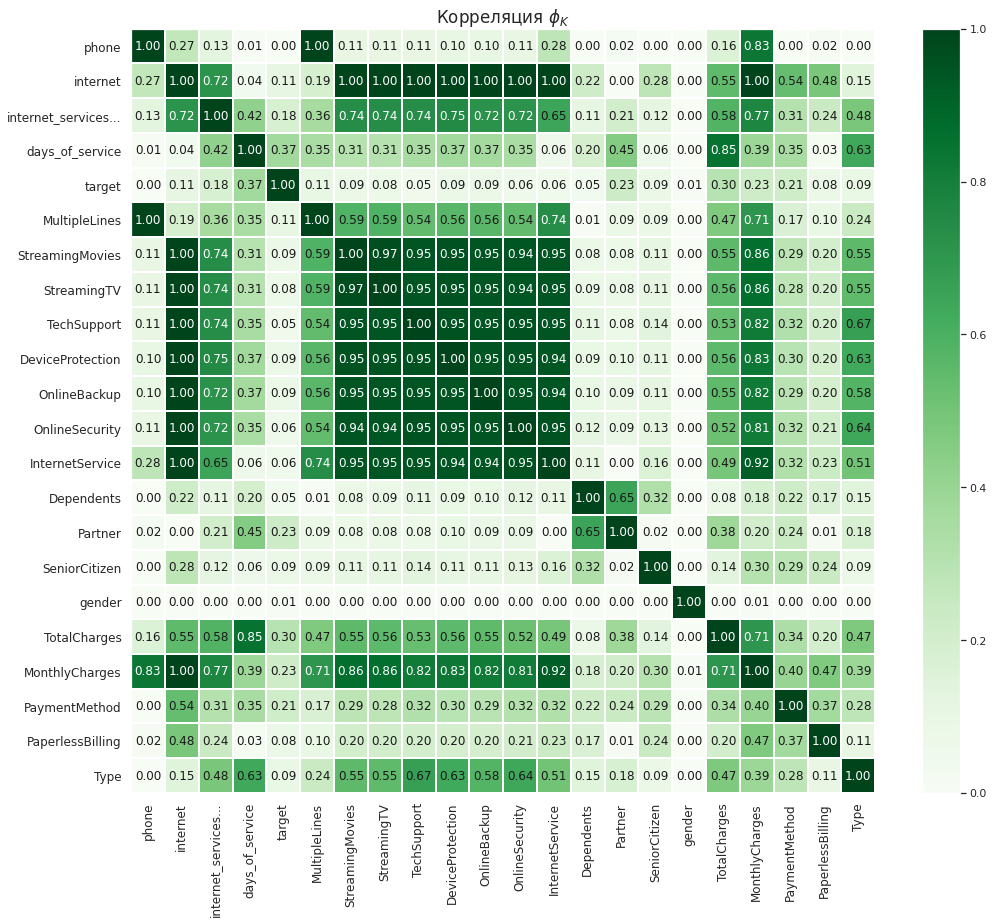

In [135]:
# визуализируем матрицу фи-коэффициентов
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map='Greens',
                        title=r'Корреляция $\phi_K$',
                        fontsize_factor=1.2,
                        figsize=(15, 13))
plt.tight_layout()

На графике хорошо заметны коэффициенты столбцов интернет-услуг: значения в них сильно коррелируют друг с другом. Это связано с тем, что у клиентов, пользующихся интернетом, как правило подключено несколько интернет-услуг. Некоторые из этих сервисов очень близки по смыслу: например, StreamingTV и StreamingMovies.

Хорошо заметна корреляция длительности договора в днях и суммарных оплат, что логично.

На графике выделяется корреляция интернет-сервиса и многоканальной телефонии: вероятно у значительной доли клиентов подключены оба этих сервиса.

Также интернет-услуги и многоканальная телефония коррелируют с размером помесячной оплаты: вероятно, чем больше дополнителньх услуг подключено, тем выше плата.

Корреляция помесячной оплаты и общей накопленной оплаты заметна, но не слишком высока. Это связано с тем, что сумма помесячной оплаты указана актуальная, а накопленная оплата складывается с течением времени и состав услуг и помесячная оплата при этом могут меняться.

Также довольно высока корреляция периодичности оплаты (Type) и интернет-услуг.

Особенно заметная отсутствующая корреляция персональных данных клиентов и прочих признаков: иждивенцы, партнеры, пенсионный статус и пол не коррелируют с услугами и оплатой. Из персональных данных коррелирует друг с другом только наличие иждивенцев и партнера.

С целевым признаком никак не коррелируют наличие телефонии и пол клиента - эти признаки можно удалить как бесполезные. Более других с целевым признаком коррелирует длительность договора в днях.

Признак наличия интернета сильно коррелирует со всеми интерент-услугам и месячной оплатой: удалим этот признак как избыточный. Информацию о наличии интернета хорошо передают другие признаки с данными о подключенных услугах.

In [136]:
# сохраним наиболее значимые признаки
features = df.drop(['gender', 'internet', 'phone', 'target'], axis=1)

# сохраним целевой признак
target = df['target']

# проверим результат
features.head(1)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_of_service,internet_services_num
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService,31,1


In [137]:
# создадим список численных признаков
num_features = ['MonthlyCharges', 'TotalCharges', 'days_of_service']

# создадим список категориальных признаков
cat_features = features.drop(num_features, axis=1).columns.tolist() 

# проверим результат
display(cat_features,
        num_features)

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'internet_services_num']

['MonthlyCharges', 'TotalCharges', 'days_of_service']

### Этап 5.5. Разделение данных на выборки

In [138]:
# разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.25,
    random_state=RS
)
# Проверим результат
display(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)

(5282, 18)

(1761, 18)

(5282,)

(1761,)

**Вывод:**

- мы успешно объединили все датасеты в один и заполнили значениями получившиеся пропуски
- мы создали целевой признак
- мы синтезировали новые признаки из имеющихся данных

- мы провели анализ фи-корреляции данных и выявили ряд закономерностей:
    - На графике хорошо заметны коэффициенты столбцов интернет-услуг: значения в них сильно коррелируют друг с другом. Это связано с тем, что у клиентов, пользующихся интернетом, как правило подключено несколько интернет-услуг. Некоторые из этих сервисов очень близки по смыслу: например, StreamingTV и StreamingMovies.
    - Хорошо заметна корреляция длительности договора в днях и суммарных оплат, что логично.

    - На графике выделяется корреляция интернет-сервиса и многоканальной телефонии: вероятно у значительной доли клиентов подключены оба этих сервиса.

    - Также интернет-услуги и многоканальная телефония коррелируют с размером помесячной оплаты: вероятно, чем больше дополнителньх услуг подключено, тем выше плата.

    - Корреляция помесячной оплаты и общей накопленной оплаты заметна, но не слишком высока. Это связано с тем, что сумма помесячной оплаты указана актуальная, а накопленная оплата складывается с течением времени и состав услуг и помесячная оплата при этом могут меняться.

    - Также довольно высока корреляция периодичности оплаты (Type) и интернет-услуг.

    - Особенно заметная отсутствующая корреляция персональных данных клиентов и прочих признаков: иждивенцы, партнеры, пенсионный статус и пол не коррелируют с услугами и оплатой. Из персональных данных коррелирует друг с другом только наличие иждивенцев и партнера.

    - С целевым признаком никак не коррелируют наличие телефонии и пол клиента - эти признаки можно удалить как бесполезные. Более других с целевым признаком коррелирует длительность договора в днях.
- мы успешно разделили данные на выборки

## Этап 6. Создание моделей

### Этап 6.1. Логистическая регрессия

In [139]:
# скопируем выборки для модели
X_train_linear = X_train.copy()
X_test_linear = X_test.copy()

# создадим трансформер для выборок 
col_transformer_linear = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [140]:
# проверим трансформер на тренировочной выборке
X_train_linear = pd.DataFrame(
    col_transformer_linear.fit_transform(X_train_linear),
    columns=col_transformer_linear.get_feature_names_out()
)

# проверим результат
display(X_train_linear.head())

# закодируем тестовую выборку
X_test_linear = pd.DataFrame(
    col_transformer_linear.transform(X_test_linear),
    columns=col_transformer_linear.get_feature_names_out()
)

# проверим результат
display(X_test_linear.head())

# вернем тренировочную выборку в исходное состояние
X_train_linear = X_train.copy()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_NoService,OnlineSecurity_NoService,OnlineSecurity_Yes,OnlineBackup_NoService,OnlineBackup_Yes,DeviceProtection_NoService,DeviceProtection_Yes,TechSupport_NoService,TechSupport_Yes,StreamingTV_NoService,StreamingTV_Yes,StreamingMovies_NoService,StreamingMovies_Yes,MultipleLines_NoService,MultipleLines_Yes,internet_services_num_1,internet_services_num_2,internet_services_num_3,internet_services_num_4,internet_services_num_5,internet_services_num_6,MonthlyCharges,TotalCharges,days_of_service
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.633974,-0.892502,-1.101968
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.662295,-0.811665,-0.919817
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.189172,0.452609,0.835053
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.486927,-0.730800,-0.020909
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.320780,-0.639988,-0.696200


,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_NoService,OnlineSecurity_NoService,OnlineSecurity_Yes,OnlineBackup_NoService,OnlineBackup_Yes,DeviceProtection_NoService,DeviceProtection_Yes,TechSupport_NoService,TechSupport_Yes,StreamingTV_NoService,StreamingTV_Yes,StreamingMovies_NoService,StreamingMovies_Yes,MultipleLines_NoService,MultipleLines_Yes,internet_services_num_1,internet_services_num_2,internet_services_num_3,internet_services_num_4,internet_services_num_5,internet_services_num_6,MonthlyCharges,TotalCharges,days_of_service
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.339106,-0.180427,0.024999
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.325333,-0.556680,0.384859
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.029064,-0.757565,-0.965724
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.326999,-0.877628,-0.832443
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.213536,2.276222,1.738403


In [141]:
%%time

# создадим модель
model_linear = LogisticRegression(penalty='l2', max_iter=10000)

# создадим пайплайн
pipeline_linear = make_pipeline(col_transformer_linear, model_linear)

# выберем сетку гиперпараметров для модели
param_grid_linear = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
}

# соберем все вместе, используем AUC-ROC в качестве метрики
gs_linear = GridSearchCV(
    pipeline_linear, 
    param_grid=param_grid_linear, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# запустим обучение и подбор
gs_linear.fit(X_train_linear, y_train)

# найдем лучшую метрику модели и соответствующие гиперпараметры 
gs_linear_best_score = gs_linear.best_score_
gs_linear_best_params = gs_linear.best_params_

# лучшее значение AUC-ROC на кросс-валидации
print(f'best_score: {gs_linear_best_score}')

# лучшие гиперпараметры
print(f'best_params: {gs_linear_best_params}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best_score: 0.7633244759972408
best_params: {'logisticregression__C': 10}
CPU times: user 8.54 s, sys: 18.9 s, total: 27.4 s
Wall time: 27.7 s


Модель оказала не очень сильный результат, но обучилась довольно быстро.

### Этап 6.2. Модель случайного леса

In [142]:
%%time

# скопируем выборки для модели
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

# создадим модель
model_rf = RandomForestClassifier(random_state=RS)

# возьмем трансформер от линейной модели
col_transformer_rf = col_transformer_linear

# создадим пайплайн
pipeline_rf = make_pipeline(col_transformer_rf, model_rf)

# выберем сетку гиперпараметров для модели
param_grid_rf = {
    'randomforestclassifier__max_depth': range(5, 9),
    'randomforestclassifier__min_samples_split': range(2, 8),
    'randomforestclassifier__min_samples_leaf': (1, 2)
}

# соберем все вместе, используем AUC-ROC в качестве метрики
gs_rf = GridSearchCV(
    pipeline_rf, 
    param_grid=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1,
    refit=True,
    error_score='raise',
    cv=3
)

# запустим обучение и подбор
gs_rf.fit(X_train_rf, y_train)

# найдем лучшую метрику модели и соответствующие гиперпараметры 
rf_best_score = gs_rf.best_score_
rf_best_params = gs_rf.best_params_

# лучшее значение AUC-ROC на кросс-валидации
print(f'best_score: {rf_best_score}')

# лучшие гиперпараметры
print(f'best_params: {rf_best_params}')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
best_score: 0.8148189398210999
best_params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 5}
CPU times: user 46.3 s, sys: 317 ms, total: 46.6 s
Wall time: 47.7 s


С этой моделью нам удалось улучшить показатель AUC-ROC, но мы все еще далеки от целевого значения.

### Этап 6.3. Модели бустинга

In [143]:
# скопируем выборки для модели
X_train_grad = X_train.copy()
X_test_grad = X_test.copy()

# поменяем тип данных в категориальных признаках с object на category
X_train_grad[cat_features] = X_train_grad[cat_features].astype('category')
X_test_grad[cat_features] = X_test_grad[cat_features].astype('category')

# проверим результат
display(X_train_grad.dtypes)

Type                     category
PaperlessBilling         category
PaymentMethod            category
MonthlyCharges            float64
TotalCharges              float64
SeniorCitizen            category
Partner                  category
Dependents               category
InternetService          category
OnlineSecurity           category
OnlineBackup             category
DeviceProtection         category
TechSupport              category
StreamingTV              category
StreamingMovies          category
MultipleLines            category
days_of_service             int64
internet_services_num    category
dtype: object

In [144]:
%%time

# создадим модель
model_light = LGBMClassifier(random_state=RS)

# выберем сетку гиперпараметров для модели
param_grid_light = {
    'learning_rate': (0.1, 0.2, 0.3),
    'max_depth': (3, 4, 5),
    'n_estimators': (100, 200, 300)
}

# соберем все вместе, используем RMSE в качестве метрики
gs_light = GridSearchCV(
    estimator=model_light, 
    param_grid=param_grid_light, 
    scoring='roc_auc', 
    n_jobs=-1,
    cv=5,
    refit=True,
    error_score='raise',
    verbose=10
)

# запустим обучение и подбор
gs_light.fit(
    X_train_grad, 
    y_train, 
    categorical_feature=cat_features,
    callbacks=[log_evaluation(period=100)]
)

# найдем лучшую метрику модели и соответствующие гиперпараметры 
light_best_score = gs_light.best_score_
light_best_params = gs_light.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {light_best_score}')

# лучшие гиперпараметры
print(f'best_params: {light_best_params}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.854 total time=   0.5s
[CV 2/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.787 total time=   0.6s
[CV 3/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.841 total time=   0.4s
[CV 4/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.837 total time=   0.5s
[CV 5/5; 1/27] START learning_rate=0.1, max_depth=3, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 1/27] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.869 total time=   0.4s
[CV 1/5; 2/27] START learning_rate=0.1, max_depth=3, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 2/27] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.884 total time=   0.7s
[CV 2/5; 2/27] START learning_rate=0.1, max_depth=3, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 2/27] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.819 total time=   0.9s
[CV 3/5; 2/27] START learning_rate=0.1, max_depth=3, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 2/27] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.863 total time=   0.8s
[CV 4/5; 2/27] START learning_rate=0.1, max_depth=3, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 2/27] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.856 total time=   1.5s
[CV 5/5; 2/27] START learning_rate=0.1, max_depth=3, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 2/27] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.894 total time=   1.0s
[CV 1/5; 3/27] START learning_rate=0.1, max_depth=3, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 3/27] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.896 total time=   1.4s
[CV 2/5; 3/27] START learning_rate=0.1, max_depth=3, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 3/27] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.836 total time=   1.0s
[CV 3/5; 3/27] START learning_rate=0.1, max_depth=3, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 3/27] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.875 total time=   1.3s
[CV 4/5; 3/27] START learning_rate=0.1, max_depth=3, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 3/27] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.867 total time=   1.1s
[CV 5/5; 3/27] START learning_rate=0.1, max_depth=3, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 3/27] END learning_rate=0.1, max_depth=3, n_estimators=300;, score=0.902 total time=   1.1s
[CV 1/5; 4/27] START learning_rate=0.1, max_depth=4, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 4/27] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.865 total time=   0.6s
[CV 2/5; 4/27] START learning_rate=0.1, max_depth=4, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 4/27] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.786 total time=   0.9s
[CV 3/5; 4/27] START learning_rate=0.1, max_depth=4, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 4/27] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.846 total time=   0.8s
[CV 4/5; 4/27] START learning_rate=0.1, max_depth=4, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 4/27] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.838 total time=   0.6s
[CV 5/5; 4/27] START learning_rate=0.1, max_depth=4, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 4/27] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.882 total time=   0.9s
[CV 1/5; 5/27] START learning_rate=0.1, max_depth=4, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 5/27] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.896 total time=   1.1s
[CV 2/5; 5/27] START learning_rate=0.1, max_depth=4, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 5/27] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.818 total time=   1.1s
[CV 3/5; 5/27] START learning_rate=0.1, max_depth=4, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 5/27] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.865 total time=   1.2s
[CV 4/5; 5/27] START learning_rate=0.1, max_depth=4, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 5/27] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.853 total time=   1.0s
[CV 5/5; 5/27] START learning_rate=0.1, max_depth=4, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 5/27] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.903 total time=   1.2s
[CV 1/5; 6/27] START learning_rate=0.1, max_depth=4, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 6/27] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.910 total time=   1.5s
[CV 2/5; 6/27] START learning_rate=0.1, max_depth=4, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 6/27] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.831 total time=   1.5s
[CV 3/5; 6/27] START learning_rate=0.1, max_depth=4, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 6/27] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.887 total time=   1.7s
[CV 4/5; 6/27] START learning_rate=0.1, max_depth=4, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 6/27] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.863 total time=   1.7s
[CV 5/5; 6/27] START learning_rate=0.1, max_depth=4, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 6/27] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.909 total time=   1.4s
[CV 1/5; 7/27] START learning_rate=0.1, max_depth=5, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 7/27] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.875 total time=   0.9s
[CV 2/5; 7/27] START learning_rate=0.1, max_depth=5, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 7/27] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.796 total time=   1.0s
[CV 3/5; 7/27] START learning_rate=0.1, max_depth=5, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 7/27] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.856 total time=   0.8s
[CV 4/5; 7/27] START learning_rate=0.1, max_depth=5, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 7/27] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.845 total time=   0.9s
[CV 5/5; 7/27] START learning_rate=0.1, max_depth=5, n_estimators=100...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 7/27] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.880 total time=   1.1s
[CV 1/5; 8/27] START learning_rate=0.1, max_depth=5, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 8/27] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.901 total time=   2.2s
[CV 2/5; 8/27] START learning_rate=0.1, max_depth=5, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 8/27] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.825 total time=   1.8s
[CV 3/5; 8/27] START learning_rate=0.1, max_depth=5, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 8/27] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.884 total time=   1.9s
[CV 4/5; 8/27] START learning_rate=0.1, max_depth=5, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 8/27] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.860 total time=   2.6s
[CV 5/5; 8/27] START learning_rate=0.1, max_depth=5, n_estimators=200...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 8/27] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.903 total time=   1.6s
[CV 1/5; 9/27] START learning_rate=0.1, max_depth=5, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 9/27] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.904 total time=   2.3s
[CV 2/5; 9/27] START learning_rate=0.1, max_depth=5, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 9/27] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.835 total time=   2.0s
[CV 3/5; 9/27] START learning_rate=0.1, max_depth=5, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 9/27] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.888 total time=   2.1s
[CV 4/5; 9/27] START learning_rate=0.1, max_depth=5, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 9/27] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.869 total time=   2.2s
[CV 5/5; 9/27] START learning_rate=0.1, max_depth=5, n_estimators=300...........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 9/27] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.908 total time=   1.7s
[CV 1/5; 10/27] START learning_rate=0.2, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 10/27] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.889 total time=   0.9s
[CV 2/5; 10/27] START learning_rate=0.2, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 10/27] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.811 total time=   0.4s
[CV 3/5; 10/27] START learning_rate=0.2, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 10/27] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.859 total time=   0.6s
[CV 4/5; 10/27] START learning_rate=0.2, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 10/27] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.850 total time=   0.4s
[CV 5/5; 10/27] START learning_rate=0.2, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 10/27] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.889 total time=   0.5s
[CV 1/5; 11/27] START learning_rate=0.2, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 11/27] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.910 total time=   0.7s
[CV 2/5; 11/27] START learning_rate=0.2, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 11/27] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.843 total time=   1.1s
[CV 3/5; 11/27] START learning_rate=0.2, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 11/27] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.882 total time=   0.7s
[CV 4/5; 11/27] START learning_rate=0.2, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 11/27] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.871 total time=   0.9s
[CV 5/5; 11/27] START learning_rate=0.2, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 11/27] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.911 total time=   0.8s
[CV 1/5; 12/27] START learning_rate=0.2, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 12/27] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.916 total time=   1.1s
[CV 2/5; 12/27] START learning_rate=0.2, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 12/27] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.855 total time=   1.1s
[CV 3/5; 12/27] START learning_rate=0.2, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 12/27] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.894 total time=   1.1s
[CV 4/5; 12/27] START learning_rate=0.2, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 12/27] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.880 total time=   1.2s
[CV 5/5; 12/27] START learning_rate=0.2, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 12/27] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.916 total time=   1.0s
[CV 1/5; 13/27] START learning_rate=0.2, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 13/27] END learning_rate=0.2, max_depth=4, n_estimators=100;, score=0.903 total time=   0.6s
[CV 2/5; 13/27] START learning_rate=0.2, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 13/27] END learning_rate=0.2, max_depth=4, n_estimators=100;, score=0.810 total time=   0.7s
[CV 3/5; 13/27] START learning_rate=0.2, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 13/27] END learning_rate=0.2, max_depth=4, n_estimators=100;, score=0.866 total time=   0.6s
[CV 4/5; 13/27] START learning_rate=0.2, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 13/27] END learning_rate=0.2, max_depth=4, n_estimators=100;, score=0.858 total time=   0.7s
[CV 5/5; 13/27] START learning_rate=0.2, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 13/27] END learning_rate=0.2, max_depth=4, n_estimators=100;, score=0.900 total time=   0.6s
[CV 1/5; 14/27] START learning_rate=0.2, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 14/27] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.915 total time=   1.2s
[CV 2/5; 14/27] START learning_rate=0.2, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 14/27] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.841 total time=   1.0s
[CV 3/5; 14/27] START learning_rate=0.2, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 14/27] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.889 total time=   1.2s
[CV 4/5; 14/27] START learning_rate=0.2, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 14/27] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.870 total time=   0.9s
[CV 5/5; 14/27] START learning_rate=0.2, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 14/27] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.916 total time=   1.3s
[CV 1/5; 15/27] START learning_rate=0.2, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 15/27] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.917 total time=   1.4s
[CV 2/5; 15/27] START learning_rate=0.2, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 15/27] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.848 total time=   1.5s
[CV 3/5; 15/27] START learning_rate=0.2, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 15/27] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.897 total time=   1.5s
[CV 4/5; 15/27] START learning_rate=0.2, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 15/27] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.876 total time=   1.4s
[CV 5/5; 15/27] START learning_rate=0.2, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 15/27] END learning_rate=0.2, max_depth=4, n_estimators=300;, score=0.918 total time=   1.5s
[CV 1/5; 16/27] START learning_rate=0.2, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 16/27] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=0.909 total time=   0.7s
[CV 2/5; 16/27] START learning_rate=0.2, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 16/27] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=0.818 total time=   1.0s
[CV 3/5; 16/27] START learning_rate=0.2, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 16/27] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=0.875 total time=   0.8s
[CV 4/5; 16/27] START learning_rate=0.2, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 16/27] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=0.857 total time=   1.0s
[CV 5/5; 16/27] START learning_rate=0.2, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 16/27] END learning_rate=0.2, max_depth=5, n_estimators=100;, score=0.901 total time=   0.8s
[CV 1/5; 17/27] START learning_rate=0.2, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 17/27] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=0.913 total time=   1.3s
[CV 2/5; 17/27] START learning_rate=0.2, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 17/27] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=0.839 total time=   1.4s
[CV 3/5; 17/27] START learning_rate=0.2, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 17/27] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=0.890 total time=   1.2s
[CV 4/5; 17/27] START learning_rate=0.2, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 17/27] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=0.867 total time=   1.4s
[CV 5/5; 17/27] START learning_rate=0.2, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 17/27] END learning_rate=0.2, max_depth=5, n_estimators=200;, score=0.907 total time=   1.5s
[CV 1/5; 18/27] START learning_rate=0.2, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 18/27] END learning_rate=0.2, max_depth=5, n_estimators=300;, score=0.918 total time=   2.2s
[CV 2/5; 18/27] START learning_rate=0.2, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 18/27] END learning_rate=0.2, max_depth=5, n_estimators=300;, score=0.844 total time=   1.7s
[CV 3/5; 18/27] START learning_rate=0.2, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 18/27] END learning_rate=0.2, max_depth=5, n_estimators=300;, score=0.888 total time=   2.2s
[CV 4/5; 18/27] START learning_rate=0.2, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 18/27] END learning_rate=0.2, max_depth=5, n_estimators=300;, score=0.865 total time=   2.7s
[CV 5/5; 18/27] START learning_rate=0.2, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 18/27] END learning_rate=0.2, max_depth=5, n_estimators=300;, score=0.910 total time=   2.2s
[CV 1/5; 19/27] START learning_rate=0.3, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 19/27] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.902 total time=   0.4s
[CV 2/5; 19/27] START learning_rate=0.3, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 19/27] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.823 total time=   0.5s
[CV 3/5; 19/27] START learning_rate=0.3, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 19/27] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.880 total time=   0.5s
[CV 4/5; 19/27] START learning_rate=0.3, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 19/27] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.863 total time=   0.7s
[CV 5/5; 19/27] START learning_rate=0.3, max_depth=3, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 19/27] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.901 total time=   0.4s
[CV 1/5; 20/27] START learning_rate=0.3, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 20/27] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.915 total time=   0.7s
[CV 2/5; 20/27] START learning_rate=0.3, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 20/27] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.852 total time=   0.8s
[CV 3/5; 20/27] START learning_rate=0.3, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 20/27] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.890 total time=   0.9s
[CV 4/5; 20/27] START learning_rate=0.3, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 20/27] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.873 total time=   1.0s
[CV 5/5; 20/27] START learning_rate=0.3, max_depth=3, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 20/27] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.914 total time=   0.9s
[CV 1/5; 21/27] START learning_rate=0.3, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 21/27] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.917 total time=   1.0s
[CV 2/5; 21/27] START learning_rate=0.3, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 21/27] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.856 total time=   1.1s
[CV 3/5; 21/27] START learning_rate=0.3, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 21/27] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.897 total time=   1.2s
[CV 4/5; 21/27] START learning_rate=0.3, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 21/27] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.878 total time=   1.1s
[CV 5/5; 21/27] START learning_rate=0.3, max_depth=3, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 21/27] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.911 total time=   1.0s
[CV 1/5; 22/27] START learning_rate=0.3, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 22/27] END learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.908 total time=   0.8s
[CV 2/5; 22/27] START learning_rate=0.3, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 22/27] END learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.832 total time=   0.7s
[CV 3/5; 22/27] START learning_rate=0.3, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 22/27] END learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.881 total time=   0.6s
[CV 4/5; 22/27] START learning_rate=0.3, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 22/27] END learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.877 total time=   0.7s
[CV 5/5; 22/27] START learning_rate=0.3, max_depth=4, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 22/27] END learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.907 total time=   0.6s
[CV 1/5; 23/27] START learning_rate=0.3, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 23/27] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.910 total time=   1.2s
[CV 2/5; 23/27] START learning_rate=0.3, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 23/27] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.847 total time=   1.0s
[CV 3/5; 23/27] START learning_rate=0.3, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 23/27] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.881 total time=   0.8s
[CV 4/5; 23/27] START learning_rate=0.3, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 23/27] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.873 total time=   1.0s
[CV 5/5; 23/27] START learning_rate=0.3, max_depth=4, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 23/27] END learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.906 total time=   1.3s
[CV 1/5; 24/27] START learning_rate=0.3, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 24/27] END learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.906 total time=   1.5s
[CV 2/5; 24/27] START learning_rate=0.3, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 24/27] END learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.844 total time=   1.5s
[CV 3/5; 24/27] START learning_rate=0.3, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 24/27] END learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.876 total time=   1.5s
[CV 4/5; 24/27] START learning_rate=0.3, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 24/27] END learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.871 total time=   1.6s
[CV 5/5; 24/27] START learning_rate=0.3, max_depth=4, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 24/27] END learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.907 total time=   1.4s
[CV 1/5; 25/27] START learning_rate=0.3, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 25/27] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.909 total time=   0.9s
[CV 2/5; 25/27] START learning_rate=0.3, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 25/27] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.819 total time=   1.1s
[CV 3/5; 25/27] START learning_rate=0.3, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 25/27] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.887 total time=   0.9s
[CV 4/5; 25/27] START learning_rate=0.3, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 25/27] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.861 total time=   0.9s
[CV 5/5; 25/27] START learning_rate=0.3, max_depth=5, n_estimators=100..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 25/27] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.897 total time=   0.9s
[CV 1/5; 26/27] START learning_rate=0.3, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 26/27] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.910 total time=   1.7s
[CV 2/5; 26/27] START learning_rate=0.3, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 26/27] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.828 total time=   3.8s
[CV 3/5; 26/27] START learning_rate=0.3, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 26/27] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.885 total time=   6.2s
[CV 4/5; 26/27] START learning_rate=0.3, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 26/27] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.864 total time=   1.8s
[CV 5/5; 26/27] START learning_rate=0.3, max_depth=5, n_estimators=200..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 26/27] END learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.904 total time=   1.3s
[CV 1/5; 27/27] START learning_rate=0.3, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 1/5; 27/27] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.910 total time=   3.7s
[CV 2/5; 27/27] START learning_rate=0.3, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 2/5; 27/27] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.840 total time=   2.0s
[CV 3/5; 27/27] START learning_rate=0.3, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 3/5; 27/27] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.884 total time=   3.5s
[CV 4/5; 27/27] START learning_rate=0.3, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 4/5; 27/27] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.860 total time=   2.3s
[CV 5/5; 27/27] START learning_rate=0.3, max_depth=5, n_estimators=300..........


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[CV 5/5; 27/27] END learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.904 total time=   2.2s


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


best_score: 0.8923262504367196
best_params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
CPU times: user 2min 47s, sys: 780 ms, total: 2min 47s
Wall time: 2min 49s


С этим классификатором получилось выйти на новый уровень качества. Модель показала отличный результат на тренировочной выборке и стала претендовать на звание лучшей.

In [145]:
%%time
import catboost

# создадим модель, используем AUC-ROC в качестве метрики
model_catboost = CatBoostClassifier(
    random_state=RS,
    cat_features=cat_features,
    eval_metric='AUC'
)

# выберем сетку гиперпараметров для модели
param_grid_catboost = {
    'learning_rate': (0.1, 0.2, 0.3),
    'depth': range(3, 9),
    'n_estimators': (100, 200, 300)
}

# соберем все вместе
model_catboost.grid_search(
    param_grid_catboost, 
    X_train_grad, 
    y_train, 
    cv=5, 
    plot=True, 
    refit=True,
    verbose=100,
    search_by_train_test_split=True
)

# сохраним лучшие гиперпараметры 
catboost_best_params = model_catboost.get_params()

# лучшие гиперпараметры
print(f'best_params: {catboost_best_params}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6292985	best: 0.6292985 (0)	total: 5.36ms	remaining: 530ms
1:	test: 0.7086617	best: 0.7086617 (1)	total: 10.3ms	remaining: 505ms
2:	test: 0.7391258	best: 0.7391258 (2)	total: 14ms	remaining: 452ms
3:	test: 0.7312978	best: 0.7391258 (2)	total: 18.1ms	remaining: 434ms
4:	test: 0.7565179	best: 0.7565179 (4)	total: 21.9ms	remaining: 417ms
5:	test: 0.7527755	best: 0.7565179 (4)	total: 26.4ms	remaining: 414ms
6:	test: 0.7574353	best: 0.7574353 (6)	total: 30.3ms	remaining: 403ms
7:	test: 0.7667947	best: 0.7667947 (7)	total: 34.2ms	remaining: 393ms
8:	test: 0.7795830	best: 0.7795830 (8)	total: 38.1ms	remaining: 386ms
9:	test: 0.7873946	best: 0.7873946 (9)	total: 41.8ms	remaining: 376ms
10:	test: 0.7893747	best: 0.7893747 (10)	total: 45.7ms	remaining: 370ms
11:	test: 0.7959454	best: 0.7959454 (11)	total: 49.7ms	remaining: 364ms
12:	test: 0.7961698	best: 0.7961698 (12)	total: 53.6ms	remaining: 359ms
13:	test: 0.8000640	best: 0.8000640 (13)	total: 57.4ms	remaining: 353ms
14:	test: 0.80

Модель продемонстрировала прекрасное качество на тренировочной выборке, но немного недотянула до показателя LightGBM Classifier. Лучшее значение AUC-ROC составило 0.8898030441

### Этап 6.4. Проверка лучшей модели

Лучший AUC-ROC в ходе обучения на кросс-валидации показала модель LightGBM Classifier. Обучим ее с лучшими гиперпараметрами:

In [146]:
# обучим лучшую модель
best_model = LGBMClassifier(random_state=RS,
                            learning_rate=0.2,
                            max_depth=3, 
                            n_estimators=300)
best_model.fit(X_train_grad, y_train)

# найдем вероятности предсказаний
preds_proba = best_model.predict_proba(X_test_grad)[:, 1]

# предскажем данные
preds = best_model.predict(X_test_grad)

Проверим модель на адекватность, сравнив с DummyClassifier:

In [147]:
# создадим dummy-модель
model_dummy = DummyClassifier()

# обучим dummy-модель и получим среднее значение
model_dummy.fit(X_train, y_train)
dummy_prediction = model_dummy.predict(X_test)

# найдем AUC-ROC dummy-модели
dummy_score = roc_auc_score(y_test, dummy_prediction)

# проверим результат
dummy_score

0.5

Далее рассчитаем AUC-ROC лучшей модели на тестовой выборке:

In [148]:
# рассчитаем AUC-ROC лучшей модели на тестовой выборке
test_roc_auc = roc_auc_score(y_test, preds_proba)
test_roc_auc

0.9161201750102155

Нам удалось достичь поставленной цели - мы создали модель, которая успешно предсказала расторжение договоров и преодолела порог AUC-ROC = 0.85 на тестовой выборке. Наша модель вполне адекватна по сревнению с DummyClassifier. Далее измерим accuracy модели и проверим как именно она ошибалась:

In [149]:
# найдем accuracy лучшей модели
accuracy_score(y_test, preds)

0.9216354344122658

Наша модель демонстрирует довольно высокий уровень accuracy.


True Positives(TP) =  1477

True Negatives(TN) =  146

False Positives(FP) =  15

False Negatives(FN) =  123


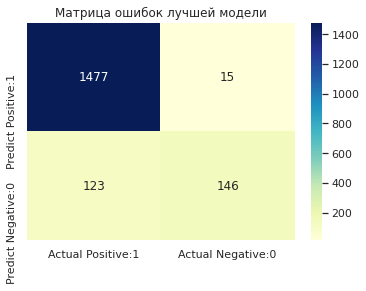

In [150]:
# найдем матрицу ошибок лучшей модели
cm = confusion_matrix(y_test, preds)

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# визуализируем матрицу ошибок лучшей модели

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, 
            annot=True, 
            fmt='d', 
            cmap='YlGnBu');
plt.title('Матрица ошибок лучшей модели')
plt.show()

Характерная черта нашей модели - она довольно часто ошибается в определении клиентов, готовых расторгнуть договор: модель пропустила 123 таких клиентов из 269 во всей тестовой выборке. Модель гораздо реже ошибалась, причисляя обычных клиентов к готовым расторгнуть договор - таких ошибок всего 15 из 1492 клиентов.

У модели есть явный перекос в предсказаниях: она с меньшей готовностью относит клиентов к группе риска, но очень точно определяет тех, кто не собирается уходить. С точки зрения экономии средств на удержание клиента такое смещение баланса выгодее, чем обратная ситуация. Тем не менее в зависимости от бизнес-задачи мы можем сместить по ROC-кривой порог предсказания и лучше определять клиентов из группы риска. Визуализируем график ROC-кривой:

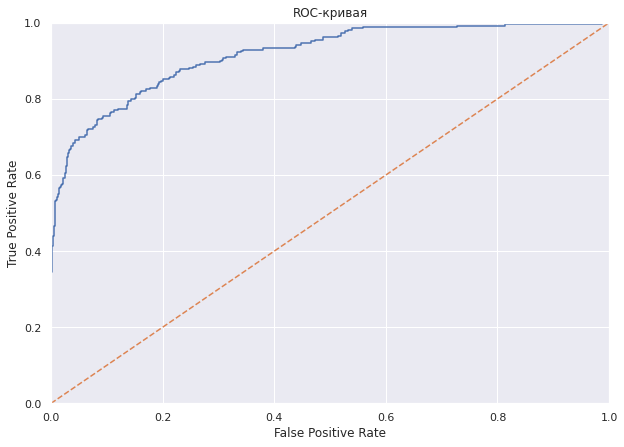

In [151]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, preds_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)

# для сравнения пунктиром отобразим на графике ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

По ROC-кривой заметно, что смещая порог предсказания класса мы можем балансировать нашу модель. Можем улучшить определение клиентов в зоне риска, точнее определяя тех, кто готов расторгнуть договор. Но это увеличит количество ложных срабатываний на тех, кто не готов расторгать договор.

Также можем смещать баланс в другую сторону, например для более экономного расходования средств на удержание клиента.

Далее визуализируем важность признаков обученной нами модели:

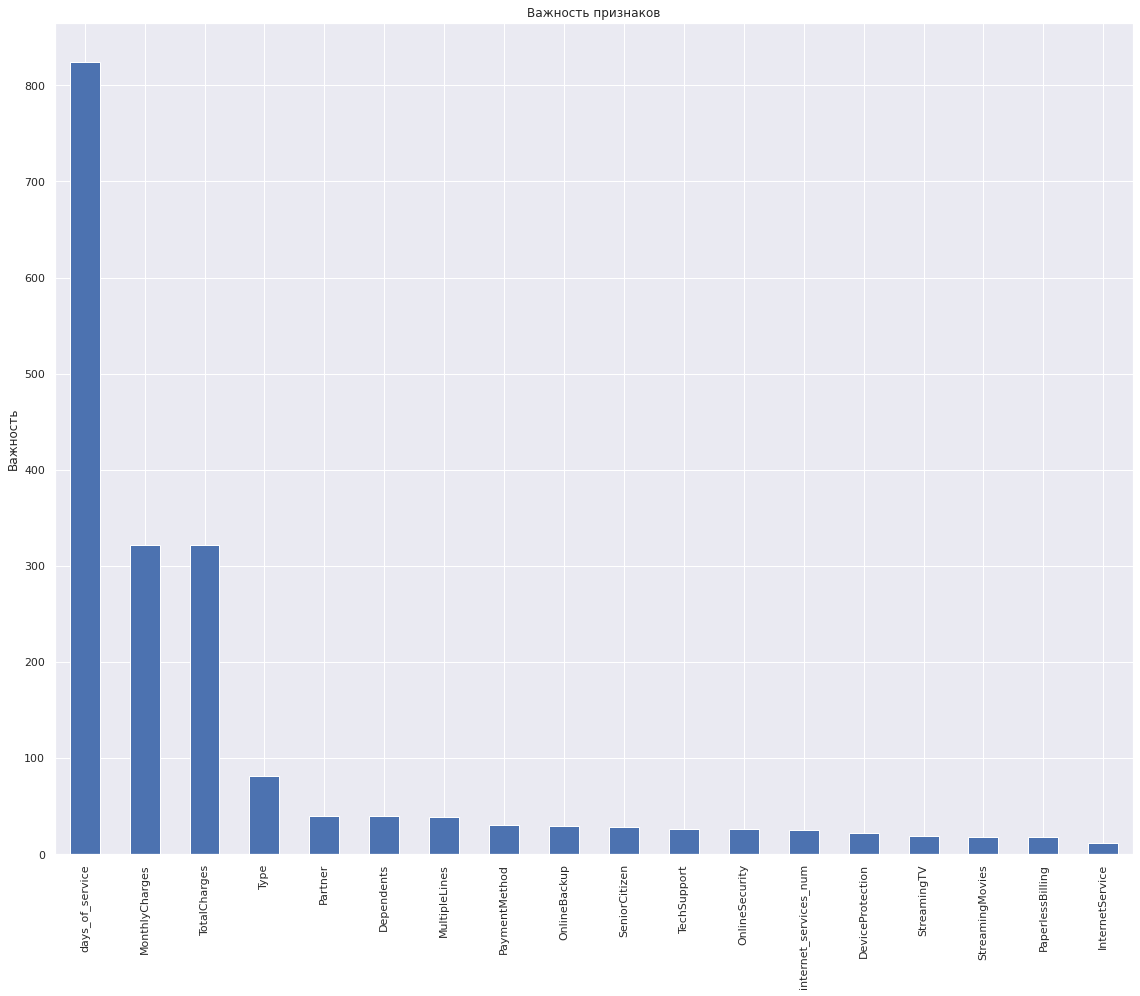

In [152]:
# извлечем из модели Series с важностью признаков
feature_importances = pd.Series(best_model.feature_importances_,
                                # отсортируем признаки по доле важности
                                features.columns).sort_values(ascending=False)

# построим график важности признаков
fig, ax = plt.subplots(figsize=(16,14))
feature_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Наиболее важный признак - количество дней действия договора. Также значимый вклад вносят признаки:
- месячной оплаты
- суммарной оплаты

Менее значимые признаки:
- периодичности оплаты
- наличия партнера
- наличия многоканальной телефонии
- метода оплаты
- бэкапа

После признака суммарной оплаты на графике следует резкий спад важности. Прочие признаки незначительно влияют на целевой признак. Можно сделать вывод, что с решением клиента уйти больше всего коррелируют срок обслуживания и стоимость услуг.

**Вывод**

Мы обучили четыре разных модели:
1. **Логистическая регрессия.** Показала самый слабый результат среди всех, но обучилась довольно быстро.
2. **Случайный лес.** С этой моделью нам удалось улучшить показатель AUC-ROC, но мы все еще были далеки от целевого значения.
3. **LightGBM Classifier.** С этим классификатором получилось выйти на новый уровень качества. Модель показала отличный результат на тренировочной выборке и стала претендовать на звание лучшей.
4. **CatBoostClassifier.** Продемонстрировал прекрасное качество на тренировочной выборке, но немного недотянул до показателя LightGBM Classifier.

- **лучшей моделью оказался LightGBM Classifier.** Мы проверили модель на адекватность: по сравнению с DummyClassifier() она показала отличный результат и адекватность. **Нам удалось преодолеть порог в AUC-ROC = 0.85. Показатель AUC-ROC лучшей модели на тестовой выборке - 0.916** 
- наша модель показала высокий уровень accuracy = 0.922, модель довольно точно делает предсказания.
- характерная черта нашей модели - она довольно часто ошибается в определении клиентов, готовых расторгнуть договор: модель пропустила 123 таких клиентов из 269 во всей тестовой выборке. Модель гораздо реже ошибалась, причисляя обычных клиентов к готовым расторгнуть договор - таких ошибок всего 15 из 1492 клиентов.
- у модели есть явный перекос в предсказаниях: она с меньшей готовностью относит клиентов к группе риска, но очень точно определяет тех, кто не собирается уходить. С точки зрения экономии средств на удержание клиента такое смещение баланса выгодее, чем обратная ситуация. Тем не менее в зависимости от бизнес-задачи мы можем сместить по ROC-кривой порог предсказания и лучше определять клиентов из группы риска. 
- смещая порог предсказания класса мы можем балансировать нашу модель. Можем улучшить определение клиентов в зоне риска, точнее определяя тех, кто готов расторгнуть договор. Но это увеличит количество ложных срабатываний на тех, кто не готов расторгать договор.
- также можем смещать баланс в другую сторону, например для более экономного расходования средств на удержание клиента.

Также мы проверили важность признаков лучшей модели:
Наиболее важный признак - количество дней действия договора. Также значимый вклад вносят признаки:
- месячной оплаты
- суммарной оплаты

Менее значимые признаки:
- периодичности оплаты
- наличия партнера
- наличия многоканальной телефонии
- метода оплаты
- бэкапа

После признака суммарной оплаты на графике следует резкий спад важности. Прочие признаки незначительно влияют на целевой признак. Можно сделать вывод, что с решением клиента уйти больше всего коррелируют срок обслуживания и стоимость услуг.

## Этап 7. Финальный вывод

**В ходе исследовательского анализа мы выяснили:**

**Договоры и клиенты:**
- нам доступны договоры, заключенные с октября 2013 по февраль 2020 включительно
- первое расторжение договора произошло в июне 2014, последнее расторжение - в январе 2020
- самый активный период заключения договоров - февраль 2014
- расторгнуто около 16% от всех заключенных договоров
- примерно 16% клиентов имеют пенсионный статус по возрасту

**Оплаты:**
- средняя оплата в месяц составляет около 64.76
- средняя оплата в год - около 2115.31
- для значительно части клиентов плата в месяц составляет около 20. Меньше всего клиентов в диапазоне 30-40 в месяц. Прочие суммы выплат распределены довольно равномерно среди клиентов
- аномально крупные суммарные выплаты принадлежат самым лояльным клиентам

**Популярность услуг:**
- наиболее популярна помесячная оплата услуг
- чаще всего применяется электронный чек
- самый популярный способ связи - оптоволокно (Fiber optic)
- чаще клиенты не пользуются услугой многоканальной телефонии (MultipleLines)

**Состояние данных:**
- в данных нет полных дубликатов строк и нет дубликатов по customerID
- в столбце TotalCharges 11 пропусков в виде пустых строк: мы заменили их на нули. Договоры с такими значенями были заключены в последний месяц сбора данных, поэтому действуют неполный месяц и данные для TotalCharges еще не успели накопиться. Поэтому нулевые значения корректны в этом случае
- мы заменили значения No в столбце EndDate на пропуски для упрощения изменения типа данных и анализа
- у столбцов BeginDate, EndDate и TotalCharges был некорректный тип данных - object. Мы заменили его на datetime для BeginDate и EndDate. Для столбца TotalCharges заменили тип данных на float64. В прочих столбцах во всех датасетах верные типы данных
- в данных нет целевого признака - факта расторжения договора. В дальнейшм мы создадим целевой признак, используя столбец EndDate

**В данных очевидна тенденция к оттоку клиентов: проблема явно требовала решения.**

**Затем мы подготовили признаки:**

1. Успешно объединили все датасеты в один и заполнили значениями получившиеся пропуски
2. Создали целевой признак
3. Синтезировали новые признаки из имеющихся данных
4. Провели анализ фи-корреляции данных и выявили ряд закономерностей:
- значения столбцов интернет-услуг сильно коррелируют друг с другом. Это связано с тем, что у клиентов, пользующихся интернетом, как правило подключено несколько интернет-услуг. Некоторые из этих сервисов очень близки по смыслу: например, StreamingTV и StreamingMovies
    - Хорошо заметна корреляция длительности договора в днях и суммарных оплат, что логично.

    - На графике выделяется корреляция интернет-сервиса и многоканальной телефонии: вероятно у значительной доли клиентов подключены оба этих сервиса.

    - Также интернет-услуги и многоканальная телефония коррелируют с размером помесячной оплаты: вероятно, чем больше дополнителньх услуг подключено, тем выше плата.

    - Корреляция помесячной оплаты и общей накопленной оплаты заметна, но не слишком высока. Это связано с тем, что сумма помесячной оплаты указана актуальная, а накопленная оплата складывается с течением времени и состав услуг и помесячная оплата при этом могут меняться.

    - Также довольно высока корреляция периодичности оплаты (Type) и интернет-услуг.

    - Особенно заметная отсутствующая корреляция персональных данных клиентов и прочих признаков: иждивенцы, партнеры, пенсионный статус и пол не коррелируют с услугами и оплатой. Из персональных данных коррелирует друг с другом только наличие иждивенцев и партнера.

    - С целевым признаком никак не коррелируют наличие телефонии и пол клиента - эти признаки можно удалить как бесполезные. Более других с целевым признаком коррелирует длительность договора в днях.

    - Признак наличия интернета сильно коррелирует со всеми интерент-услугам и месячной оплатой: удалим этот признак как избыточный. Информацию о наличии интернета хорошо передают другие признаки с данными о подключенных услугах.
5. Успешно разделили данные на выборки

**Создали и обучили модели на кросс-валидации:**

1. **Логистическая регрессия.** Показала самый слабый результат среди всех, но обучилась довольно быстро.
2. **Случайный лес.** С этой моделью нам удалось улучшить показатель AUC-ROC, но мы все еще были далеки от целевого значения.
3. **LightGBM Classifier.** С этим классификатором получилось выйти на новый уровень качества. Модель показала отличный результат на тренировочной выборке и стала претендовать на звание лучшей.
4. **CatBoostClassifier.** Продемонстрировал прекрасное качество на тренировочной выборке, но немного недотянул до показателя LightGBM Classifier.


- **лучшей моделью оказался LightGBM Classifier.** Мы проверили модель на адекватность: по сравнению с DummyClassifier() она показала отличный результат и адекватность. **Нам удалось преодолеть порог в AUC-ROC = 0.85. Показатель AUC-ROC лучшей модели на тестовой выборке - 0.916** 
- наша модель показала высокий уровень accuracy = 0.922, модель довольно точно делает предсказания.
- характерная черта нашей модели - она довольно часто ошибается в определении клиентов, готовых расторгнуть договор: модель пропустила 123 таких клиентов из 269 во всей тестовой выборке. Модель гораздо реже ошибалась, причисляя обычных клиентов к готовым расторгнуть договор - таких ошибок всего 15 из 1492 клиентов.
- у модели есть явный перекос в предсказаниях: она с меньшей готовностью относит клиентов к группе риска, но очень точно определяет тех, кто не собирается уходить. С точки зрения экономии средств на удержание клиента такое смещение баланса выгодее, чем обратная ситуация. Тем не менее в зависимости от бизнес-задачи мы можем сместить по ROC-кривой порог предсказания и лучше определять клиентов из группы риска. 
- смещая порог предсказания класса мы можем балансировать нашу модель. Можем улучшить определение клиентов в зоне риска, точнее определяя тех, кто готов расторгнуть договор. Но это увеличит количество ложных срабатываний на тех, кто не готов расторгать договор.
- также можем смещать баланс в другую сторону, например для более экономного расходования средств на удержание клиента.

Также мы проверили важность признаков лучшей модели:

Наиболее важный признак - количество дней действия договора. Также значимый вклад вносят признаки:
- месячной оплаты
- суммарной оплаты

Менее значимые признаки:
- периодичности оплаты
- наличия партнера
- наличия многоканальной телефонии
- метода оплаты
- бэкапа

После признака суммарной оплаты на графике следует резкий спад важности. Прочие признаки незначительно влияют на целевой признак. Можно сделать вывод, что с решением клиента уйти больше всего коррелируют срок обслуживания и стоимость услуг.

**Нам удалось создать модель машинного обучения, решающую задачу бинарной классификации: предсказание факта расторжения клиентом договора. Наша модель успешно преодолела порог AUC-ROC = 0.85 на тестовой выборке. Цель проекта достигнута.**

## Этап 8. Отчет по проекту

1. **Выполнение плана**. Мы выполнили все пункты примерного плана работы с небольшими правками: мы не проводили предварительно кодирование и масштабирование признаков, но включили эти работы в пайплайн моделей логистической регресии и случайного леса. Использование пайплайнов помогло использовать другую обработку данных для моделей бустинга.


2. **Проблемы в ходе работы:** 

    Слишком долгое обучение моделей бустинга на GridSearch. Причина крылась в гиперпаметре learning_rate: малые значения параметра серьезно замедляли обучение моделей. Мы увеличили значения learning_rate до значений 0.1 - 0.3. Это помогло ускорить обучение в десятки раз.
    
    
3. **Ключевые шаги в решении задачи:**
    - **Предварительное исследование данных.** Помогло нам понять структуру и особенности данных, выявить пропуски и некорректные типы данных. Также мы выяснили, что в датасетах нет целевого признака, но его можно сгенерировать на основе других столбцов. Исследование данных подтвердило проблему ухода клиентов и позволило наметить примерный план дальнейшей работы по проекту.
    - **Создание плана работы и постановка цели.** Этот этап структурировал дальнейшую работу по проекту и конкретизировал цель работы.
    - **Подготовка признаков.** Помогла отфильтровать несущественные и вредные для обучения данные, а также обогатить датасет важнейшим признаком длительности договора.
    - **Создание моделей.** Этот этап позволил выявить и протестировать лучшую модель, а также констатировать достижение цели проекта.
    - **Финальные выводы**. Стали квинтэссеницией проделанной работы. Структурировали всю информацию, полученную по ходу проекта в удобном для ознакомления виде.
    
    
4. **Признаки**
    - **Как обработали признаки:**
         1. Пустые строки в 'TotalCharges' заменили нулями, изменили тип данных в столбце на float64
         2. Значения No в столбце 'EndDate' заполнили датой выгрузки датасета.
         3. У столбцов 'BeginDate', 'EndDate' изменили тип данных на datetime
         4. Объединили датасеты методом merge, используя параметр how='outer'
         5. В объединенных данных заполнили пропуски значением NoService
         6. Создали целевой признак, используя значения в столбце 'EndDate'
         7. Сгенерировали признаки:
             - 'internet_services_num': означает количество интернет-сервисов, подключенных у клиента
             - 'days_of_service': означает количество дней действия договора. Мы получили его из дат заключения и расторжения договора. Для действующих договоров вместо даты расторжения использовали дату выгрузки датасета.
         8. Для обучения моделей логистической регрессии и случайного леса: 
             - кодировали категориальные признаки при помощи OneHotEncoder из sklearn, используя параметры drop='first'и handle_unknown='ignore'. 
             - численные признаки кодировали через StandartScaler из sklearn
             - упаковали кодирование в трансформер, а трансформер поместили в пайплайн моделей
         9. Для обучения моделй бустинга поменяли тип данных в категориальных признаках на category и передали список названий категориальных признаков моделям.        
<br>
<br>
    - **Признаки, которые мы использовали для обучения моделей:**
        - **Категориальные:**
            - 'Type',
            - 'PaperlessBilling'
            - 'PaymentMethod'
            - 'SeniorCitizen'
            - 'Partner'
            - 'Dependents'
            - 'InternetService'
            - 'OnlineSecurity'
            - 'OnlineBackup'
            - 'DeviceProtection'
            - 'TechSupport'
            - 'StreamingTV'
            - 'StreamingMovies'
            - 'MultipleLines'
            - 'internet_services_num': сгенерированный нами признак, означает количество интернет-сервисов, подключенных у клиента
    
        - **Численные:**
            - 'MonthlyCharges'
            - 'TotalCharges'
            - 'days_of_service': сгенерированный нами признак, означает количество дней действия договора. Мы получили его из дат заключения и расторжения договора. Для действующих договоров вместо даты расторжения использовали дату выгрузки датасета.    
<br>
<br>
    - **Признаки, которые мы удалили после обработки:**
        - 'gender'. Не коррелирует с прочими данными. Бесполезен для обучения моделей.
        - 'customerID'. Не несет полезной информации.
        - 'BeginDate' и 'EndDate'. Вызывают утечку целевого признака.


5. **Итоговая модель.** 
    - Наша модель - **LGBMClassifier** со следующими гиперпараметрами:
        - learning_rate=0.2,
        - max_depth=3, 
        - n_estimators=300
    - **Результаты модели** при использовании random_state=140823:
        - AUC-ROC на тестовой выборке ~ 0.916
        - accuracy на тестовой выборке ~ 0.922
        - матрица ошибок:
            - True Positives(TP) =  1477
            - True Negatives(TN) =  146
            - False Positives(FP) =  15
            - False Negatives(FN) =  123
    - **Результаты модели на графиках:**

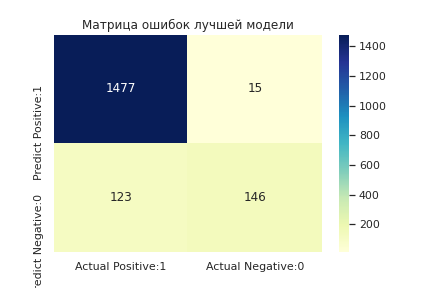
Характерная черта нашей модели - она довольно часто ошибается в определении клиентов, готовых расторгнуть договор: модель пропустила 123 таких клиентов из 269 во всей тестовой выборке. Модель гораздо реже ошибалась, причисляя обычных клиентов к готовым расторгнуть договор - таких ошибок всего 15 из 1492 клиентов.

У модели есть явный перекос в предсказаниях: она с меньшей готовностью относит клиентов к группе риска, но очень точно определяет тех, кто не собирается уходить. С точки зрения экономии средств на удержание клиента такое смещение баланса выгодее, чем обратная ситуация. Тем не менее в зависимости от бизнес-задачи мы можем сместить по ROC-кривой порог предсказания и лучше определять клиентов из группы риска. 

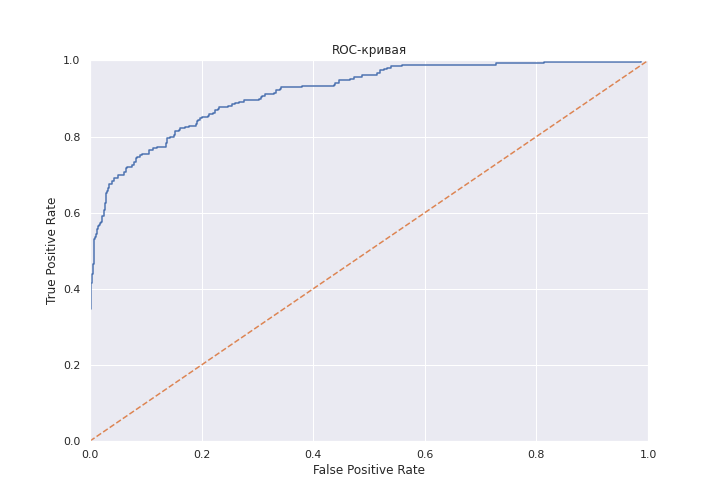
По ROC-кривой заметно, что смещая порог предсказания класса мы можем балансировать нашу модель. Можем улучшить определение клиентов в зоне риска, точнее определяя тех, кто готов расторгнуть договор. Но это увеличит количество ложных срабатываний на тех, кто не готов расторгать договор.

Также можем смещать баланс в другую сторону, например для более экономного расходования средств на удержание клиента.

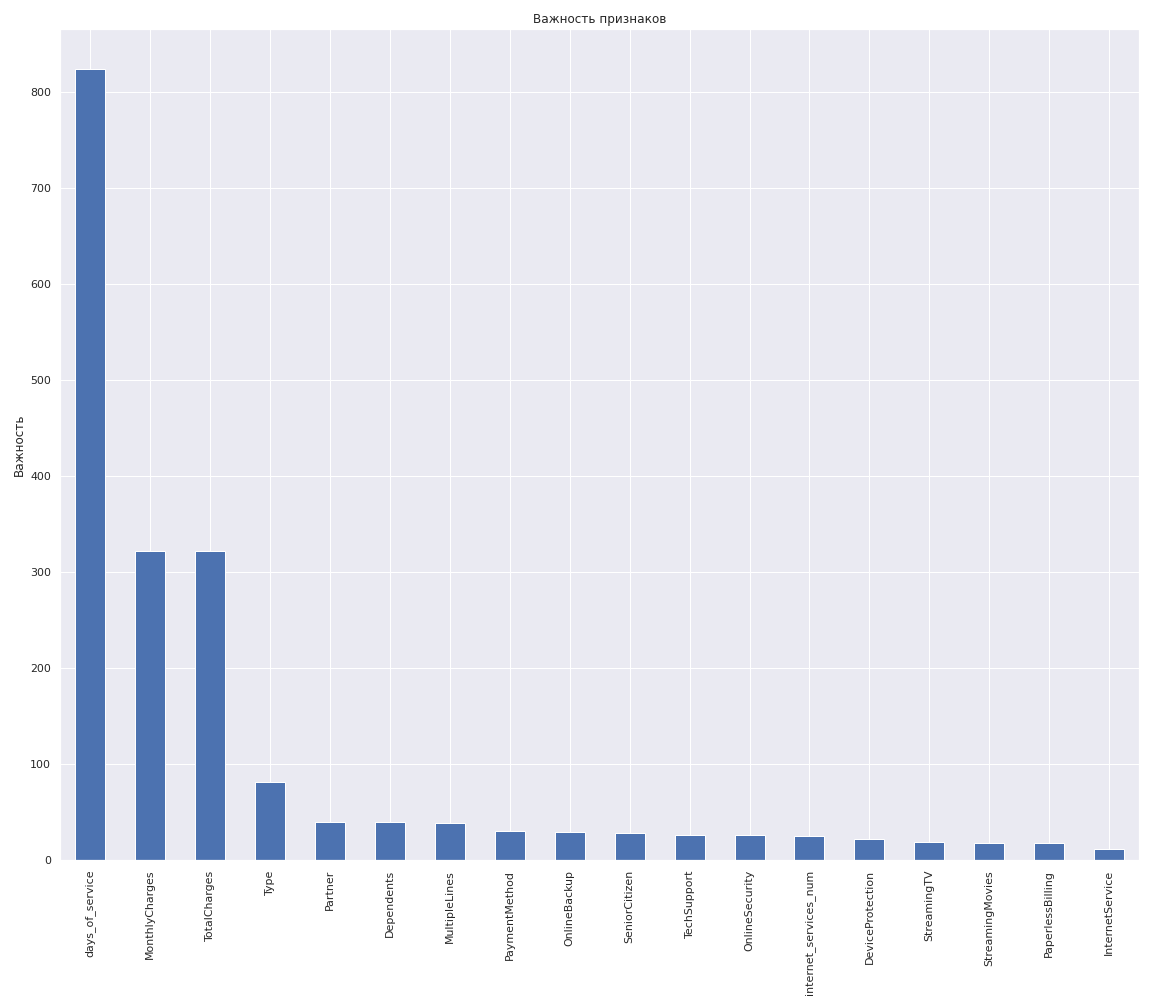
Наиболее важный признак - количество дней действия договора. Также значимый вклад вносят признаки:
- месячной оплаты
- суммарной оплаты

Менее значимые признаки:
- периодичности оплаты
- наличия партнера
- наличия многоканальной телефонии
- метода оплаты
- бэкапа

После признака суммарной оплаты на графике следует резкий спад важности. Прочие признаки незначительно влияют на целевой признак. Можно сделать вывод, что с решением клиента уйти больше всего коррелируют срок обслуживания и стоимость услуг.